In [24]:
import numpy as np
import matplotlib.pyplot as plt
import Library as lb
import tensorflow as tf
from tensorflow import keras

Training the model

In [25]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,    
  decay_steps=100,
  decay_rate=2,
  staircase=True)

def custom_loss(y_true, y_pred):
    return tf.keras.losses.cosine_similarity(y_true,y_pred) + 30*tf.keras.losses.huber(y_true,y_pred)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000, batch_size=32):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=custom_loss,
                metrics=[
                  tf.keras.losses.MeanSquaredError("auto", "mean_squared_error")])

    model.summary()

    # train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    # train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)

    # val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # val_dataset = val_dataset.batch(batch_size)

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test,y_test),
            callbacks=get_callbacks(name),
            batch_size = batch_size,
            verbose=2)

    return history

# Loading training dataset
folder = 'Burgers_time'
input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

INPUTDIM = (input_train.shape[1],)
OUTPUTDIM = (output_train.shape[1],)

# Creting model
model = lb.FNO(INPUTDIM, OUTPUTDIM, p_dim=512, n=3, k_max=17, verbose=True, model_name='Burgers_time_FNO', dropout=0.01, kernel_reg=0.001)
history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, batch_size=60 , max_epochs=5000)



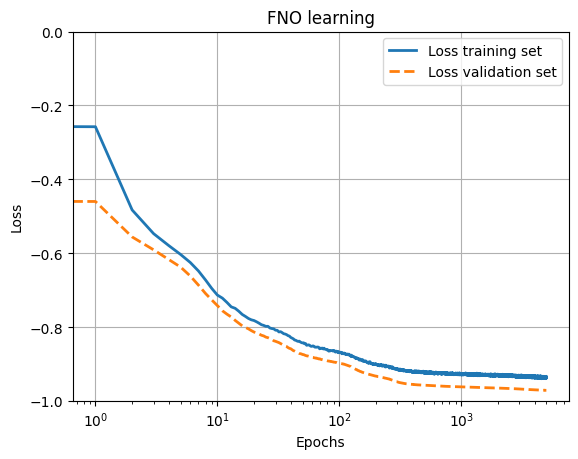

In [43]:
bc     = history.history['loss']
val_bc = history.history['val_loss']

plt.semilogx(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.semilogx(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('FNO learning')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([-1,0])
plt.legend(('Loss training set','Loss validation set'))
plt.savefig('../Burgers_time_FNO.png', dpi=300)
plt.show()

113/113 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Training set - index: 460')

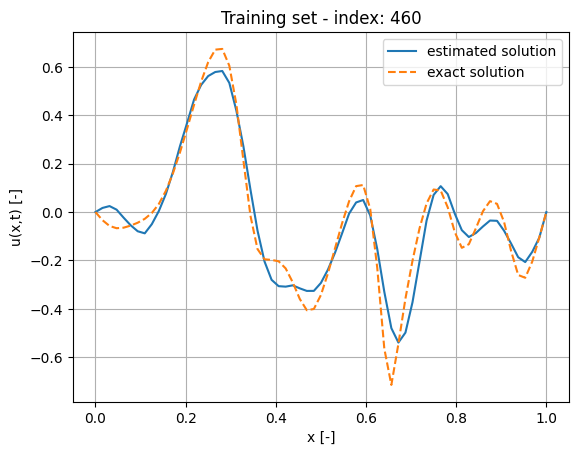

In [50]:
from random import randint

rec_output = model.predict(input_train)
index = randint(0, input_train.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_train[index,:], label='exact solution', linestyle='--')
# plt.plot(xx,input_test[index,:], label='input', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Training set - index: '+ str(index))

29/29 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Test set - index: 584')

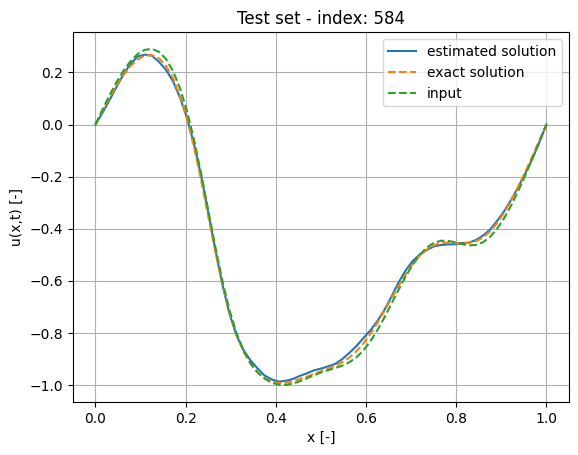

In [62]:
from random import randint

rec_output = model.predict(input_test)
index = randint(0, input_test.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.plot(xx,input_test[index,:], label='input', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))

In [64]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/'+folder+'/Burgers_time_FNO.h5')
    print('FNO saved in '+str(folder))
else:
    print('FNO not saved')

FNO saved in Burgers_time_new


Loading the model

In [2]:
folder = 'Burgers_time'
loaded_model = keras.models.load_model('../data/'+folder+'/Burgers_time_FNO.h5', compile=False)

fft_shape set: 17
ifft_shape set: 32
Bias layer has shape: 32
fft_shape set: 17
ifft_shape set: 32
Bias layer has shape: 32
fft_shape set: 17
ifft_shape set: 32
Bias layer has shape: 32


In [3]:
input_test=np.load('../data/' + folder + '/input_test.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

29/29 [==============================] - 0s 4ms/step


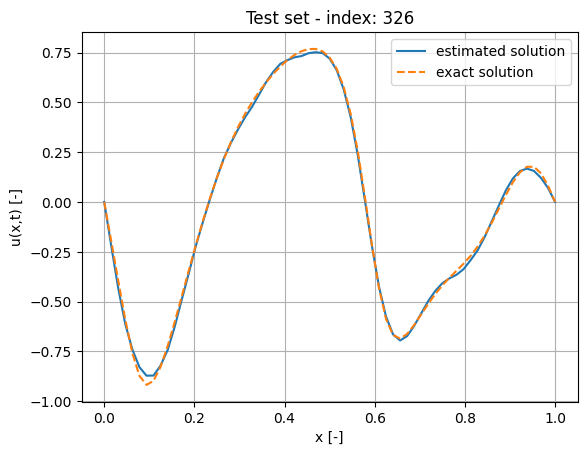

In [23]:
from random import randint
rec_output = loaded_model.predict(input_test)
index = randint(0, input_test.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))
plt.savefig('../Burgers_time_test_'+str(index)+'.png', dpi=300)

Improve training

In [302]:
lr_schedule(5000)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00019607843>

In [303]:
# improve training
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  2e-4,    
  decay_steps=50,
  decay_rate=2,
  staircase=True)

def custom_loss(y_true, y_pred):
    return tf.keras.losses.cosine_similarity(y_true,y_pred) + 10*tf.keras.losses.huber(y_true,y_pred)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000, batch_size=32):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=custom_loss,
                metrics=[
                  tf.keras.losses.MeanSquaredError("auto", "mean_squared_error")])

    model.summary()

    # train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    # train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)

    # val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # val_dataset = val_dataset.batch(batch_size)

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test,y_test),
            callbacks=get_callbacks(name),
            batch_size = batch_size,
            verbose=2)

    return history

history = compile_and_fit(loaded_model, loaded_model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, batch_size=60, max_epochs=5000)



Model: "Burgers_time_FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 65)]              0         
                                                                 
 P_layer (Dense)             (None, 600)               39600     
                                                                 
 dropout_64 (Dropout)        (None, 600)               0         
                                                                 
 fourier_layer_0 (Fourier_La  (None, 28)               17025     
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 28)               1009      
 yer)                                                            
                                                                 
 fourier_layer_2 (Fourier_La  (None, 28)          

Epoch 1/5000
60/60 - 14s - loss: -8.2774e-01 - mean_squared_error: 0.0026 - val_loss: -7.9835e-01 - val_mean_squared_error: 0.0028 - 14s/epoch - 229ms/step
Epoch 2/5000
60/60 - 3s - loss: -8.3420e-01 - mean_squared_error: 0.0025 - val_loss: -7.9986e-01 - val_mean_squared_error: 0.0028 - 3s/epoch - 49ms/step
Epoch 3/5000
60/60 - 3s - loss: -8.3540e-01 - mean_squared_error: 0.0025 - val_loss: -7.9979e-01 - val_mean_squared_error: 0.0028 - 3s/epoch - 47ms/step
Epoch 4/5000
60/60 - 3s - loss: -8.3583e-01 - mean_squared_error: 0.0025 - val_loss: -7.9988e-01 - val_mean_squared_error: 0.0028 - 3s/epoch - 46ms/step
Epoch 5/5000
60/60 - 3s - loss: -8.3596e-01 - mean_squared_error: 0.0025 - val_loss: -8.0000e-01 - val_mean_squared_error: 0.0028 - 3s/epoch - 46ms/step
Epoch 6/5000
60/60 - 3s - loss: -8.3605e-01 - mean_squared_error: 0.0025 - val_loss: -7.9984e-01 - val_mean_squared_error: 0.0028 - 3s/epoch - 46ms/step
Epoch 7/5000
60/60 - 3s - loss: -8.3613e-01 - mean_squared_error: 0.0025 - val_

29/29 [==============================] - 0s 14ms/step


Text(0.5, 1.0, 'Test set - index: 220')

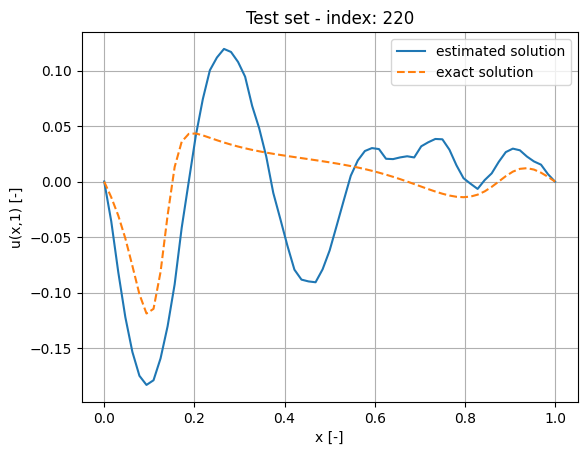

In [175]:
from random import randint
rec_output = loaded_model.predict(input_test)
index = randint(0, input_test.shape[0]-1)
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
plt.legend()
plt.ylabel('u(x,1) [-]')
plt.xlabel('x [-]')
plt.title('Test set - index: '+ str(index))
# plt.savefig('../Burgers_time_test_'+str(index)+'.png', dpi=300)

Save the improved model

In [176]:
save_NN = False
# save_NN = True
if save_NN:
    loaded_model.save('../data/'+folder+'/Burgers_time_FNO.h5')
    print('FNO saved in '+str(folder))
else:
    print('FNO not saved')

FNO saved in Burgers_time_new
